# 乱使用的ipynb文件

# 目的是查看查看维度结构使用

从给出数据的格式来看，使用json读取更合适一些

In [1]:
import numpy as np
word2ix = np.load('vocab.npy', allow_pickle='TRUE').item() 

In [2]:
# 读入数据
import json
import pandas as pd
import numpy as np
import collections, numpy
f = open('data.json') 
data = json.load(f)

print(len(data))
print(data[0]['label'])
print(data[0]['label'][0][0])

3000
[['TICKER', [20, 25]], ['NOTIONAL', [5, 19]]]
TICKER


共有 2220个两标签， 780个三标签的数据

每个数据都有 **'NOTIONAL'** , **'TICKER'** 两种标签

三标签数据含有一个额外的 **'NAME'** 标签

In [9]:
# -------------Let’s start implementing----------------------
# Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk


# -------------Let’s prepare data for training our doc2vec model----------------------
data = ["I love machine learning. Its awesome.",
        "I love coding in python",
        "I love building chatbots",
        "they chat amagingly well"]

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
print (tagged_data)



[TaggedDocument(words=['i', 'love', 'machine', 'learning', '.', 'its', 'awesome', '.'], tags=['0']), TaggedDocument(words=['i', 'love', 'coding', 'in', 'python'], tags=['1']), TaggedDocument(words=['i', 'love', 'building', 'chatbots'], tags=['2']), TaggedDocument(words=['they', 'chat', 'amagingly', 'well'], tags=['3'])]


d:\Anaconda_install\envs\myenv\lib\site-packages\ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()


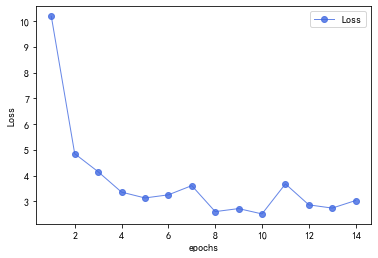

In [14]:
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 添加这条可以让图形显示中文

import pandas as pd
df = pd.read_csv('train_situation.csv')

x_axis_data = df['epoch'].tolist()
y_axis_data = df['loss'].tolist()
y2 = df['f1 score'].tolist()
# plot中参数的含义分别是横轴值，纵轴值，线的形状，颜色，透明度,线的宽度和标签
plt.plot(x_axis_data, y_axis_data, 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label='Loss')

# 显示标签，如果不加这句，即使在plot中加了label='一些数字'的参数，最终还是不会显示标签
plt.legend(loc="upper right")
plt.xlabel('epochs')
plt.ylabel('Loss')

plt.show()


d:\Anaconda_install\envs\myenv\lib\site-packages\ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  if sys.path[0] == '':


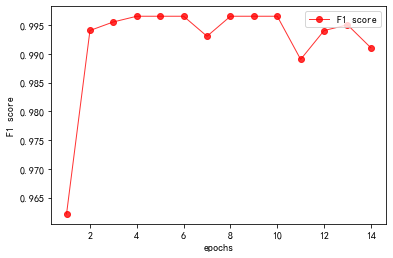

In [16]:
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 添加这条可以让图形显示中文

import pandas as pd
df = pd.read_csv('train_situation.csv')

x_axis_data = df['epoch'].tolist()
y_axis_data = df['loss'].tolist()
y2 = df['f1 score'].tolist()
# plot中参数的含义分别是横轴值，纵轴值，线的形状，颜色，透明度,线的宽度和标签
# plt.plot(x_axis_data, y_axis_data, 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label='Loss')
plt.plot(x_axis_data, y2, 'ro-', color='red', alpha=0.8, linewidth=1, label='F1 score')

# 显示标签，如果不加这句，即使在plot中加了label='一些数字'的参数，最终还是不会显示标签
plt.legend(loc="upper right")
plt.xlabel('epochs')
plt.ylabel('F1 score')

plt.show()


In [1]:
# 读入数据
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from model import BiLSTM_CRF
import torch.optim as optim
import torch
from train import train, test
from metric import f1_score
def extreact(raw_data):
    # 改造数据
    # BIO Tagging
    all_data = []
    x = []
    y = []
    for d in raw_data:
        text = d['text'].split()
        text = [_t.lower() for _t in text]
        sen_label = [] #['o'] * len(text)
        labels = d['label']
        char_label = ['O'] * len(d['text'])
        for la in labels:
            start_index = la[1][0]
            end_index = la[1][1]
            char_label[start_index] = 'B-' + la[0]
            for i in range(start_index + 1, end_index):
                char_label[i] = 'I-' + la[0]
        # print(char_label)
        sen_label.append(char_label[0])
        for j in range (0,len(d['text'])):
            if d['text'][j] == ' ' and j != len(d['text']) - 1 and j != 0:
                # print(j)
                sen_label.append(char_label[j+1])

        x.append(text)
        y.append(sen_label)
        tri = (text,sen_label)
        # print(tri)
        all_data.append(tri)

    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
    x_dev,x_test,y_dev,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state=0)

    print("x_train is:"); print(len(x_train))
    print("y_train is:"); print(len(y_train))
    print("x_dev is:");  print(len(x_test))
    print("y_dev is:");  print(len(y_test))
    print("x_test is:");  print(len(x_test))
    print("y_test is:");  print(len(y_test))
    
    word_to_ix = {} # 词表
    for sentence, tags in all_data:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
    
    np.save('vocab.npy', word_to_ix)
    return x_train, y_train, x_dev, y_dev, x_test, y_test, word_to_ix
f = open('data.json') 
# 数据部分
data = json.load(f)
print('--------Data load--------')
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

print(device)
x_train, y_train, x_dev, y_dev, x_test, y_test, word2id = extreact(data)

--------Data load--------
cuda
x_train is:
2100
y_train is:
2100
x_dev is:
450
y_dev is:
450
x_test is:
450
y_test is:
450


In [2]:
from data_loader import NERDataset
# 序列字典 
START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag2id = {
    "O": 0, 
    "B-NAME": 1, 
    "I-NAME": 2,
    "B-NOTIONAL": 4, 
    "I-NOTIONAL": 5,
    "B-TICKER": 6, 
    "I-TICKER": 7,
    START_TAG: 8, 
    STOP_TAG: 9,
    '[CLS]': 10,
    '[SEP]': 11
}

train_dataset = NERDataset(x_train, y_train, word2id, tag2id)

['dear', 'zachary', 'haas', 'buy', '357.052', 'bilzf']
['put', '845.268trillion', 'bldp']
['dear', '818.456million', 'tu', 'sell']
['sell', '446.366trillion', 'wprt']
['812.9m', 'nnxpf']
['sell', '375.765million', 'ng']
['hello', 'david', 'stewart', '859.29million', 'uuuu']
['hi', 'tiffany', 'wilson', 'may', 'i', '26.209billion', 'cpg', 'thx.']
['hi', '873.573', 'pds']
['hi', 'may', 'i', 'buy', '500.588b', 'gtbif', 'thx.']
['272.128thousand', 'zfsvf', 'call']
['may', 'i', '457.247billion', 'acdvf', 'put']
['hi', 'brittany', 'gordon', 'buy', '918.753trillion', 'ccj']
['470.549thousand', 'ivpaf', 'put']
['kevin', 'whitehead', ',', '10.994million', 'oyief']
['hi', 'buy', '635.85b', 'slf']
['hi', 'carlos', 'gray', '237.179billion', 'fnv']
['hello', '668.181b', 'eevvf', 'buy']
['put', '279.414thousand', 'misvf']
['581.013trillion', 'aleaf']
['hi', 'corey', 'thompson', '723.643hundred', 'plprf', 'buy']
['hi', 'angela', 'carpenter', 'may', 'i', '429.735b', 'auxxf', 'sell', 'thank', 'you.']
['

In [24]:
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(x_train)]

In [26]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk

model = Doc2Vec(vector_size=200,
                alpha= 0.025,
                min_alpha=0.00025,
                min_count=1,
                dm=1)

model.build_vocab(tagged_data)

In [29]:
for epoch in range(100):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [45]:
model.wv.key_to_index

{'i': 0,
 'may': 1,
 'can': 2,
 'call': 3,
 'buy': 4,
 'put': 5,
 'sell': 6,
 'hi': 7,
 ',': 8,
 'hello': 9,
 'dear': 10,
 'thx.': 11,
 'thanks': 12,
 'thank': 13,
 'you.': 14,
 'smith': 15,
 'jones': 16,
 'michael': 17,
 'james': 18,
 'robert': 19,
 'taylor': 20,
 'otex': 21,
 'thomas': 22,
 'kiq': 23,
 'vet': 24,
 'gnenf': 25,
 'vryyf': 26,
 'akzof': 27,
 'john': 28,
 'daniel': 29,
 'johnson': 30,
 'heoff': 31,
 'cukpf': 32,
 'glaxf': 33,
 'ng': 34,
 'david': 35,
 'zom': 36,
 'joseph': 37,
 'hrvsf': 38,
 'grin': 39,
 'trbmf': 40,
 'stephanie': 41,
 'vextf': 42,
 'cbwtf': 43,
 'ero': 44,
 'uuraf': 45,
 'kelly': 46,
 'crhcf': 47,
 'jdcmf': 48,
 'glvmf': 49,
 'trssf': 50,
 'ntthf': 51,
 'brown': 52,
 'long': 53,
 'takof': 54,
 'plsdf': 55,
 'mbaif': 56,
 'auph': 57,
 'white': 58,
 'ipoof': 59,
 'shrmf': 60,
 'wowmf': 61,
 'hitif': 62,
 'mkgaf': 63,
 'williams': 64,
 'yndx': 65,
 'fvanf': 66,
 'plg': 67,
 'lyscf': 68,
 'opssf': 69,
 'tgb': 70,
 'nexcf': 71,
 'svkef': 72,
 'vygvf': 73,
 '

In [47]:
from gensim.models.doc2vec import Doc2Vec

model = Doc2Vec.load("d2v.model")
# to find the vector of a document which is not in training data
test_data = word_tokenize("dasddqwd".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

V1_infer [ 2.0566463e-04  4.3549418e-04  1.9743377e-03 -1.5015337e-03
  5.4881605e-04 -2.4820156e-03 -6.8338541e-04  5.0930830e-04
  5.1539479e-04 -9.0612454e-04 -3.2000185e-04 -1.7716968e-03
  9.5141592e-04  6.1981467e-04 -1.1950581e-03 -2.1794080e-03
 -3.0192570e-04 -2.3943789e-03  2.1691180e-03 -2.4519854e-03
  1.2494423e-03 -8.8615270e-05  1.7761365e-03 -8.8921678e-04
  8.3323062e-04 -1.4098083e-03  6.3698977e-04  8.7876618e-04
  1.8560732e-03 -7.9628822e-05 -7.4915064e-04 -1.5459565e-03
 -1.7006648e-03  1.5217194e-03 -3.5979301e-05 -2.3466423e-04
 -2.6948511e-04 -3.3184185e-04 -1.3377910e-03 -5.8117358e-04
  2.8461128e-04 -2.2549625e-03 -1.2208120e-04 -1.6294584e-03
  2.3433148e-04 -1.7567851e-03  1.6153434e-03  1.8143770e-03
 -2.2418379e-04 -1.4237768e-03 -1.0781476e-03 -1.8114171e-03
  1.4121464e-03 -1.5328091e-03 -3.2081918e-04  1.2714907e-03
  2.2747339e-04  1.1409819e-03 -5.8192504e-04  5.0372480e-05
  2.0904941e-03  2.4340152e-05 -2.3752262e-03  1.0077348e-03
 -2.4792508e-03

In [31]:
print(len(v1))

200


In [7]:
# 统计一下标签的种类数目

f = open('data.json') 
data = json.load(f)

num_label = []
for da in data:
    label = len(da['label'])
    num_label.append(label)

print ("单标签样本数： {}".format(num_label.count(1)))
print ("两标签样本数： {}".format(num_label.count(2)))
print ("三标签样本数： {}".format(num_label.count(3)))
print ("四标签样本数： {}".format(num_label.count(4)))

dic_label = []
for da in data:
    for la in da['label']:
        dic_label.append(la[0])

dic_label = np.array(dic_label)
unique, counts = numpy.unique(dic_label,return_counts=True)

print("标签分布情况：{}".format(dict(zip(unique,counts))))

单标签样本数： 0
两标签样本数： 2220
三标签样本数： 780
四标签样本数： 0
标签分布情况：{'NAME': 780, 'NOTIONAL': 3000, 'TICKER': 3000}


改造数据 + 划分训练集和测试集

In [3]:
# 改造数据
# BIO Tagging
from tracemalloc import start

f = open('data.json') 
raw_data = json.load(f)

all_data = []
x = []
y = []
for d in raw_data:
    text = d['text'].split()
    sen_label = [] #['o'] * len(text)
    labels = d['label']
    char_label = ['O'] * len(d['text'])
    for la in labels:
        start_index = la[1][0]
        end_index = la[1][1]
        char_label[start_index] = 'B-' + la[0]
        for i in range(start_index + 1, end_index):
            char_label[i] = 'I-' + la[0]
    # print(char_label)
    sen_label.append(char_label[0])
    for j in range (0,len(d['text'])):
        if d['text'][j] == ' ' and j != len(d['text']) - 1 and j != 0:
            # print(j)
            sen_label.append(char_label[j+1])
    # print(text)
    # print(sen_label)
    x.append(text)
    y.append(sen_label)
    tri = (text,sen_label)
    # print(tri)
    all_data.append(tri)


from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

print("x_train is:"); print(len(x_train))
print("y_train is:"); print(len(y_train))
print("x_test is:");  print(len(x_test))
print("y_test is:");  print(len(y_test))

train_data = []
test_data = []

for i in range(0,len(x_train)):
    # print(x_train[i])
    # print(y_train[i])
    tri = (x_train[i],y_train[i])
    train_data.append(tri)

for i in range(0,len(x_test)):
    # print(x_train[i])
    # print(y_train[i])
    tri = (x_test[i],y_test[i])
    test_data.append(tri)


x_train is:
2100
y_train is:
2100
x_test is:
900
y_test is:
900


In [11]:
# 划分训练集和测试集
from torch.utils.data import Dataset
from transformers import BertTokenizer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import logging
import torch
import tqdm


START_TAG = "<START>"
STOP_TAG = "<STOP>"

# 序列字典 
tag_to_ix = {
    "O": 0, 
    "B-NAME": 1, 
    "I-NAME": 2,
    "B-NOTIONAL": 4, 
    "I-NOTIONAL": 5,
    "B-TICKER": 6, 
    "I-TICKER": 7,
    START_TAG: 8, 
    STOP_TAG: 9,
    '[CLS]': 10,
    '[SEP]': 11
}

word_to_ix = {} # 词表
for sentence, tags in all_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

class NERDataset(Dataset):

    def __init__(self, words, labels, vocab, label2id):
        self.vocab = vocab
        self.dataset = self.preprocess(words, labels)
        self.label2id = label2id

    def preprocess(self, words, labels):
        """convert the data to ids"""
        processed = []
        for (word, label) in zip(words, labels):
            word_id = [self.vocab.word_id(w_) for w_ in word]
            label_id = [self.vocab.label_id(l_) for l_ in label]
            processed.append((word_id, label_id))
        print("-------- Process Done! --------")
        return processed

    def __getitem__(self, idx):
        word = self.dataset[idx][0]
        label = self.dataset[idx][1]
        return [word, label]

    def __len__(self):
        return len(self.dataset)

    def get_long_tensor(self, texts, labels, batch_size):

        token_len = max([len(x) for x in texts])
        text_tokens = torch.LongTensor(batch_size, token_len).fill_(0)
        label_tokens = torch.LongTensor(batch_size, token_len).fill_(0)
        mask_tokens = torch.ByteTensor(batch_size, token_len).fill_(0)

        for i, s in enumerate(zip(texts, labels)):
            text_tokens[i, :len(s[0])] = torch.LongTensor(s[0])
            label_tokens[i, :len(s[1])] = torch.LongTensor(s[1])
            mask_tokens[i, :len(s[0])] = torch.tensor([1] * len(s[0]), dtype=torch.uint8)

        return text_tokens, label_tokens, mask_tokens

    def collate_fn(self, batch):

        texts = [x[0] for x in batch]
        labels = [x[1] for x in batch]
        lens = [len(x) for x in texts]
        batch_size = len(batch)

        input_ids, label_ids, input_mask = self.get_long_tensor(texts, labels, batch_size)

        return [input_ids, label_ids, input_mask, lens]

ImportError: cannot import name 'data' from 'torchtext.data.datasets_utils' (d:\Anaconda_install\envs\myenv\lib\site-packages\torchtext\data\datasets_utils.py)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
print(torch.__version__)
print(torch.cuda.is_available())
import torchtext
print(torchtext.__version__)

1.12.1
True
0.13.1


In [7]:
# 建立模型
import torch
import torch.nn as nn
import torch.optim as optim
print(torch.__version__)
print(torch.cuda.is_available())

EMBEDDING_DIM = 5
HIDDEN_DIM = 4
torch.manual_seed(1)

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full([self.tagset_size], -10000.)
        # START_TAG has all of the score.
        init_alphas[self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        # Iterate through the sentence
        forward_var_list=[]
        forward_var_list.append(init_alphas)
        for feat_index in range(feats.shape[0]):
            gamar_r_l = torch.stack([forward_var_list[feat_index]] * feats.shape[1])
            t_r1_k = torch.unsqueeze(feats[feat_index],0).transpose(0,1)
            aa = gamar_r_l + t_r1_k + self.transitions
            forward_var_list.append(torch.logsumexp(aa,dim=1))
        terminal_var = forward_var_list[-1] + self.transitions[self.tag_to_ix[STOP_TAG]]
        terminal_var = torch.unsqueeze(terminal_var,0)
        alpha = torch.logsumexp(terminal_var, dim=1)[0]
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []
        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var_list = []
        forward_var_list.append(init_vvars)

        for feat_index in range(feats.shape[0]):
            gamar_r_l = torch.stack([forward_var_list[feat_index]] * feats.shape[1])
            gamar_r_l = torch.squeeze(gamar_r_l)
            next_tag_var = gamar_r_l + self.transitions
            viterbivars_t,bptrs_t = torch.max(next_tag_var,dim=1)

            t_r1_k = torch.unsqueeze(feats[feat_index], 0)
            forward_var_new = torch.unsqueeze(viterbivars_t,0) + t_r1_k

            forward_var_list.append(forward_var_new)
            backpointers.append(bptrs_t.tolist())

        # Transition to STOP_TAG
        terminal_var = forward_var_list[-1] + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = torch.argmax(terminal_var).tolist()
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path


    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq


In [11]:
# 文本序列转数字序列
device = 'cuda' if torch.cuda.is_available() else 'cpu'
            
precheck_sent = prepare_sequence(train_data[0][0], word_to_ix)
precheck_tags = np.array([tag_to_ix[t] for t in train_data[0][1]])

print(len(word_to_ix))
print(train_data[0][0])
print(precheck_sent)
print(precheck_tags)


4270
['Dear', '568.763million', 'AXNVF']
[0 1 2]
[0 4 6]


In [3]:
import metric 
y_true = [['O', 'O', 'O', 'B-NAME', 'I-NAME', 'I-NAME', 'O'], ['B-TICKER', 'I-TICKER', 'O']]
y_pred = [['O', 'O', 'B-NAME', 'I-NAME', 'I-NAME', 'I-NAME', 'O'], ['B-TICKER', 'I-TICKER', 'O']]
f1_labels, f1 =  metric.final_eval(y_true, y_pred)
print(f1_labels)

{'NAME': 0, 'NOTIONAL': 0, 'TICKER': 1.0}


In [4]:
import metric 
y_true = [['O', 'O', 'O', 'B-NAME', 'I-NAME', 'I-NAME', 'O'], ['B-TICKER', 'I-TICKER', 'O']]
y_pred = [['O', 'O', 'B-NAME', 'I-NAME', 'I-NAME', 'I-NAME', 'O'], ['B-TICKER', 'I-TICKER', 'O']]
f1 =  metric.f1_score(y_true, y_pred)

[('NAME', 3, 5), ('TICKER', 8, 9)]


In [13]:
import pandas as pd
a = pd.DataFrame([f1_labels])
a

,NAME,NOTIONAL,TICKER
0,0,0,1.0


In [5]:
seq = [['B-PER', 'I-PER'], ['O', 'B-LOC']]
if any(isinstance(s, list) for s in seq):
    seq = [item for sublist in seq for item in sublist + ['O']]
print(seq)

['B-PER', 'I-PER', 'O', 'O', 'B-LOC', 'O']


In [ ]:

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM).cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [1]:
import torch.nn as nn
import torch
x = torch.rand(10,24,100)
lstm = nn.LSTM(100,16,num_layers=2)
output,(h,c) = lstm(x)
print(output.size())
print(h.size())
print(c.size())


torch.Size([10, 24, 16])
torch.Size([2, 24, 16])
torch.Size([2, 24, 16])
